# ERP Preprocessing and Derivation Using MNE
This notebook reads in a raw, continuous EEG data file with trigger codes, saved in EEGLAB format (.set/.fdt), and preprocesses it (including filtering, segmentation, artifact detection/ICA correction), and plots means for each experimental condition, along with differences.

This relies on the MNE-python package, and several python libraries. At the least, to run this you'll need to do the following:
- download and install miniconda from continuum.org
- once miniconda is installed, open a Terminal (OS X) or Anaconda prompt (Windows), and enter the floowing commands:
    - `conda install numpy scipy pandas matplotlib scikit-learn jupyter`
    - `pip install mne`
- once those commands have run, you would type `jupyter notebook` and then load this notebook's `.ipynb` file

---
Copyright (c) 2016 Aaron J Newman, NeuroCognitive Imaging Lab, Dalhousie University

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.

## Load in the necessary libraries/packages we'll need

In [1]:
import numpy as np
import matplotlib
import mne
from mne.io.reference import set_eeg_reference
mne.set_log_level('error')

## Set Parameters

In [2]:
# change this for each individual subject
subject = 'facestudy_RA'

# './' specifies that data are in the same directory as this notebook
data_path = './' 

# Input should be continuous EEG data in EEGLAB format, named as [subject].set
raw_fname = data_path + subject + '.set'

# Your names for each condition of interest in your experiemnt. Should have distinct trigger code(s) for each condition
cond_of_interest = ['Fix', 'Upright', 'Inverted']

# For each cond_of_interest, here you list the associated trigger code
event_id = {'Fix':10, 'Upright':11, 'Inverted':12}

# For 3137 lab data, use Fp1 [0]
eog_inds = [0]

# specify the time window for epoching
tmin = -0.1  # start of each epoch (in sec)
tmax = 0.6  # end of each epoch (in sec)

# Filter cutoffs and other parameters
l_freq = 0.1
h_freq = 40.0
l_trans_bandwidth = 0.025 # for comparability with EEGLAB: transition bandwidth is 25% of the lower passband edge, but not lower than 2 Hz
h_trans_bandwidth = 10
filter_length='45s'

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run
n_max_ecg = 3
n_max_eog = 3
# Specify n_components as a decimal to set % explained variance
n_components = .99


#################################################################
# It's unlikely you will want to change any settings below here

baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1005'

# output file names - set to follow MNE conventions
events_fname = data_path + subject + '-eve.fif'
epochs_fname  = data_path + subject + '-epo.fif'
evoked_fname = data_path + subject + '-ave.fif'
covariance_fname = data_path + subject + '-cov.fif'
trans_name = data_path + subject + '-trans.fif'
forward_fname = data_path + subject + '-fwd.fif'
inverse_fname = data_path + subject + '-inv.fif'

## Import data

In [3]:
raw = mne.io.read_raw_eeglab(raw_fname, eog=eog_inds, event_id=event_id, preload=True)  

## Set electrode positions

In [4]:
raw.set_montage(mne.channels.read_montage(montage_fname))

## Filtering

First plot frequency spectrum prior to filtering, for later comparison

In [9]:
%matplotlib inline
raw.plot_psd(fmax=100);

UsageError: unrecognized arguments: # generally, use this for figures


### Now bandpass filter, then plot filtered data

c:\users\aaron\documents\github\mne-python\mne\viz\raw.py:585: UserWarning: In version 0.15 average will default to False and spatial_colors to True.
  warn('In version 0.15 average will default to False and '


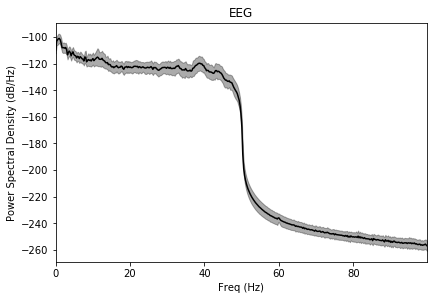

In [7]:
raw.filter(l_freq, h_freq, l_trans_bandwidth = l_trans_bandwidth, h_trans_bandwidth = h_trans_bandwidth, 
           filter_length=filter_length, method='fft', n_jobs = 6)  
raw.plot_psd(fmax=100);

### Zoom in on frequency range of interest

c:\users\aaron\documents\github\mne-python\mne\viz\raw.py:585: UserWarning: In version 0.15 average will default to False and spatial_colors to True.
  warn('In version 0.15 average will default to False and '


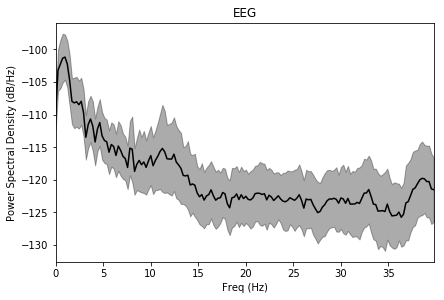

In [8]:
raw.plot_psd(fmax=40);

## Interactive plot of continuous data - identify and mark bad channels
Scroll through the plot to identify channels for exclusion from analysis

[Sometimes the matplotlib notebook plots fail to draw properly. Just re-run the cell and it should work. Also, you can rezise the plot with the grey triangle in the bottom R corner. This seems especially slow in Chrome.]


<IPython.core.display.Javascript object>


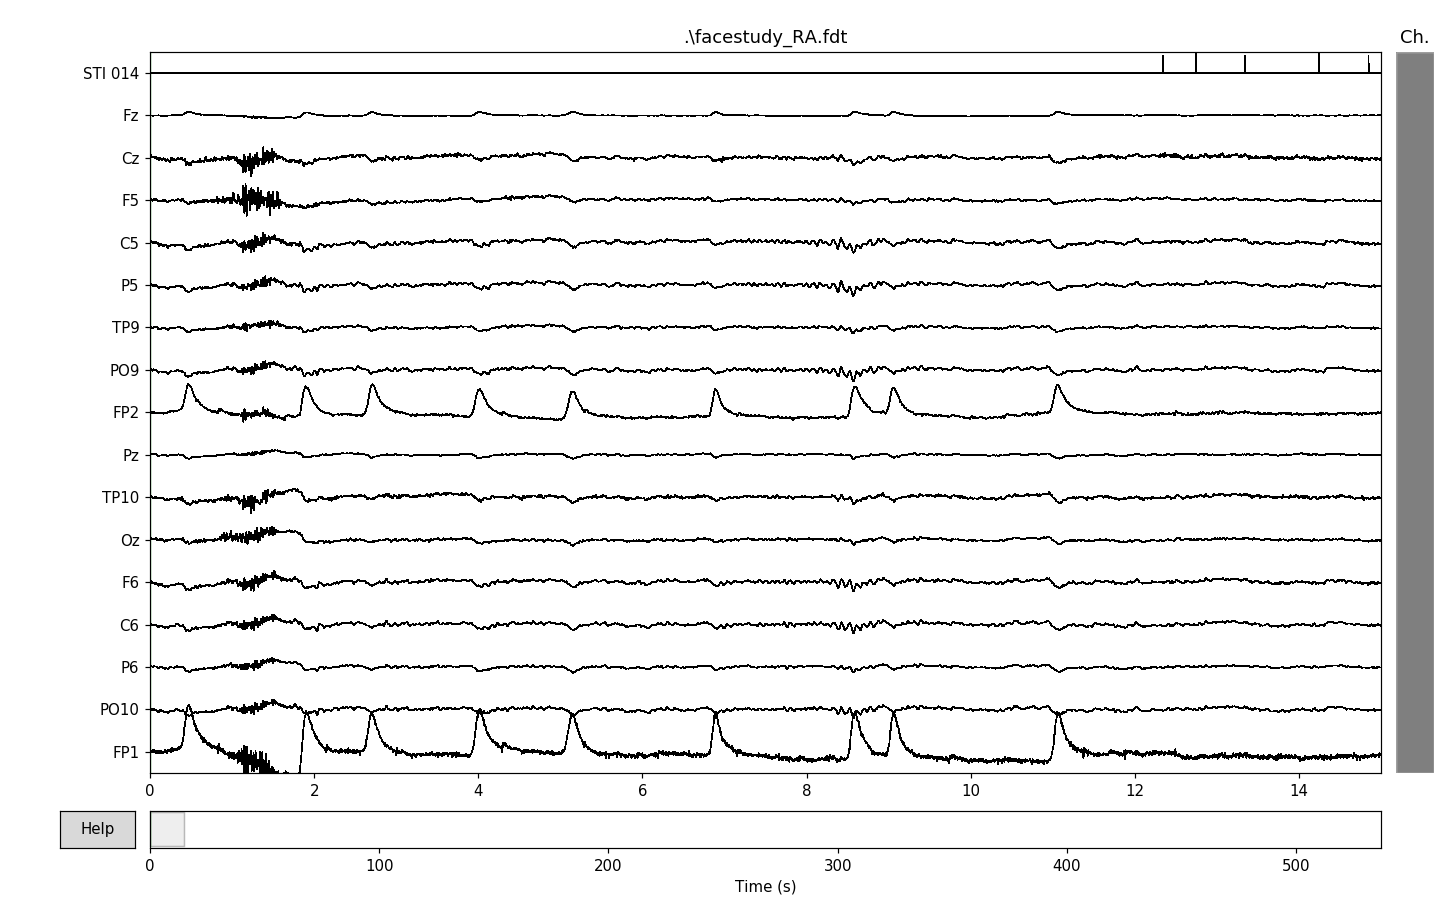

In [53]:
%matplotlib notebook
raw.plot(n_channels=17, scalings=dict(eeg=200e-6), duration=15); 


List any bad channels that you found in the interactive plot, in 'bads':

In [12]:
raw.info['bads'] = []

## Event Processing
Event codes are stored in a 'channel' called STI 014

In [13]:
events = mne.find_events(raw, stim_channel='STI 014')
mne.write_events(events_fname, events)

### Visualize code positions over time

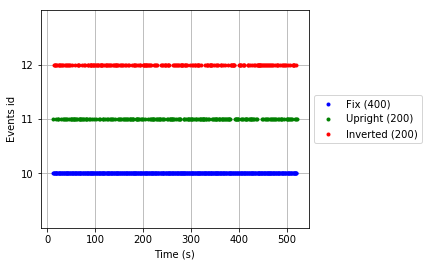

In [15]:
%matplotlib inline
fig = mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id);

## Epoching

In [18]:
# Define EEG channels
picks_eeg = mne.pick_types(raw.info, eeg=True, eog=True,
                           stim=False, exclude=[])  # we need to keep the bads in the list

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks_eeg, baseline=baseline, preload=True)

print(epochs) # gives us number of trials per condition prior to artrej

<Epochs  |  n_events : 800 (all good), tmin : -0.1 (s), tmax : 0.6 (s), baseline : (None, 0), ~34.3 MB, data loaded,
 'Fix': 400, 'Inverted': 200, 'Upright': 200>


## Plot epochs and go through, manually marking bad trials
Click on a trial to mark it bad. When you close the window, the marked trials will be saved to the "drops" in the epochs data structure.

<IPython.core.display.Javascript object>


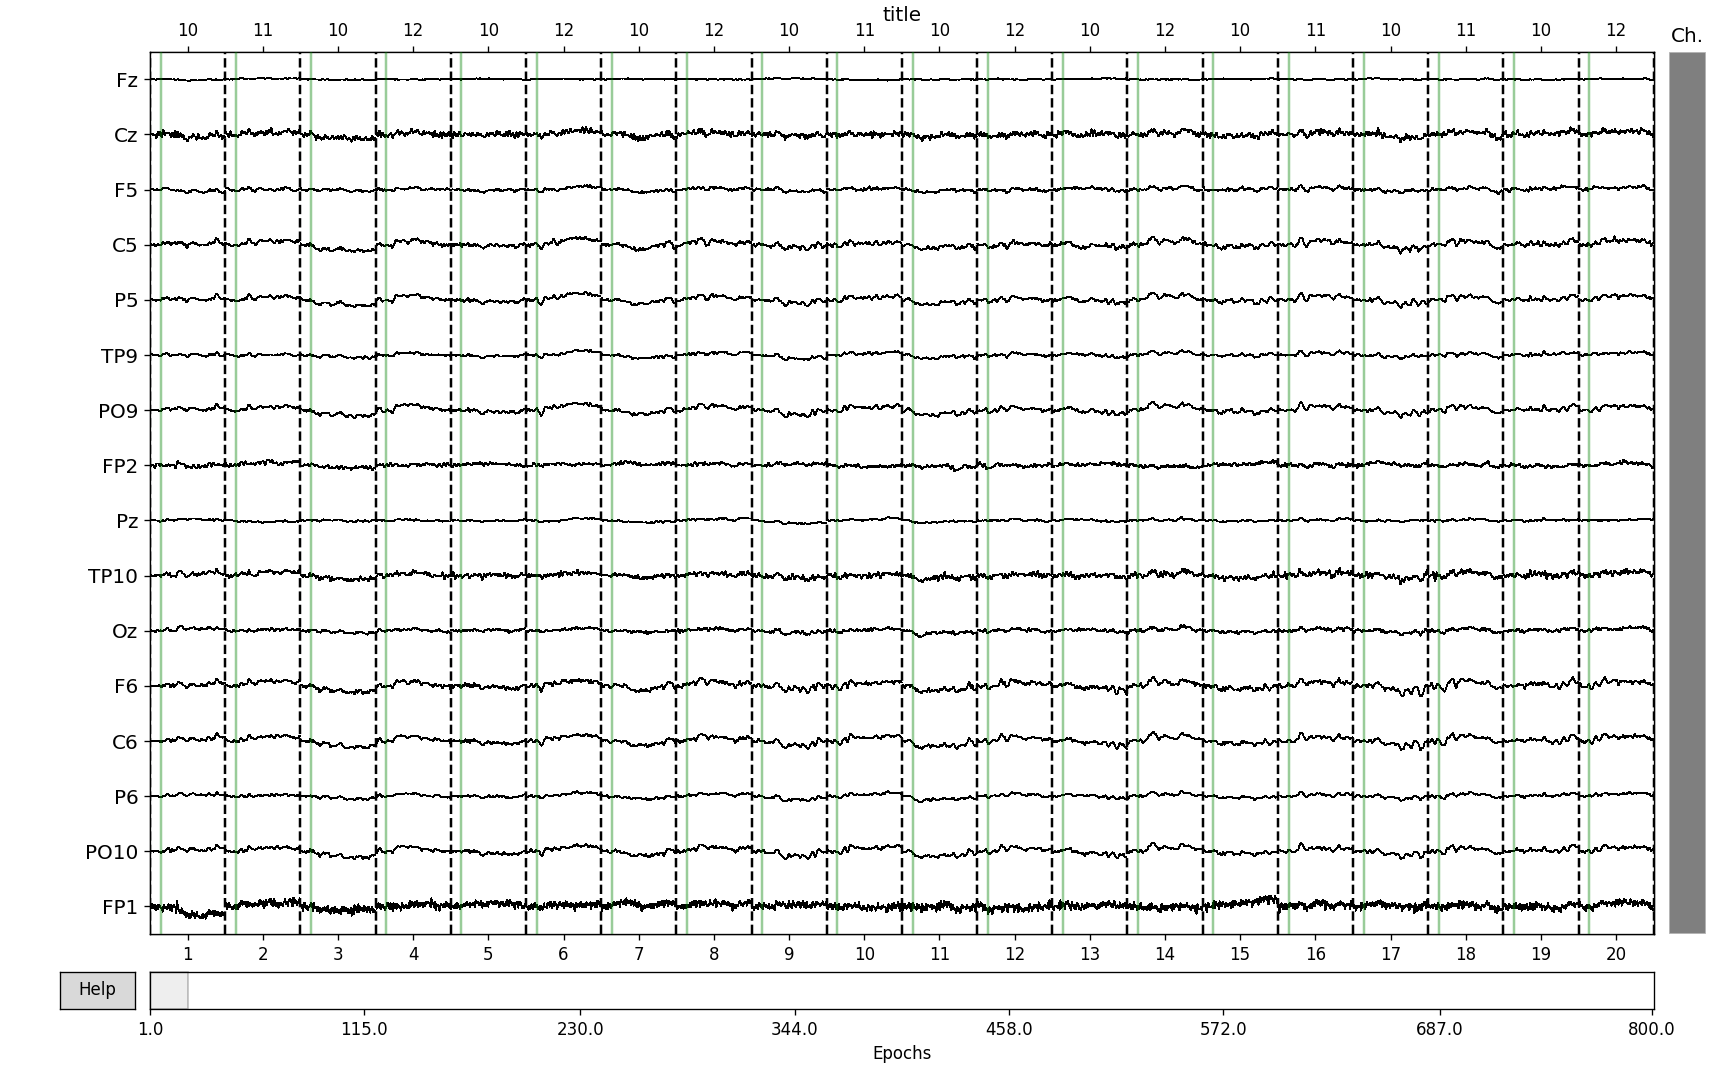

In [19]:
%matplotlib notebook
epochs.plot(scalings=dict(eeg=200e-6), n_channels=66, title='title', picks=picks_eeg);

#### Reproducable science
The problem with manual rejection through the GUI is that we don't have a record here in the script of which trials were rejected. So if we have to redo this step, it might be done differently, which will affect all subsequent steps (notably ICA).

Therefore, we identify the bad trials visually, but exclude them manually by listing them in the cell below.

Note that an alternative way to reject trials is to click on them in the interactive plot above. They will turn red and are then removed from the data structure for all subsequent steps. 
*BE CAREFUL* though, becuase *MNE renumbers the trials after rejection*. So, if you click on trials in the interactive plot, then list those trial numbers below and run `epochs.drop`, you will remove *double* the number of trials you intended - the latter half being actually-good trials.
Also, the "click" method is not a reproducible science approach, because if you re-run this notebook, you will have to re-identify and -mark the bad trials. So **do not use the click-to-reject approach**.


In [21]:
rej_trials = [386,387,388,389,390,391,435,436,473,482,483,484,485,711,712,781,782,783,784,785]
# indices in epochs.plot() start from 1, not 0, so we need to -1 from each index we manually identified
for k in range(len(rej_trials)):
    rej_trials[k] = rej_trials[k]-1
    
epochs.drop(rej_trials)

<Epochs  |  n_events : 780 (all good), tmin : -0.1 (s), tmax : 0.6 (s), baseline : (None, 0), ~33.5 MB, data loaded,
 'Fix': 389, 'Inverted': 199, 'Upright': 192>

### Plot average of all epochs

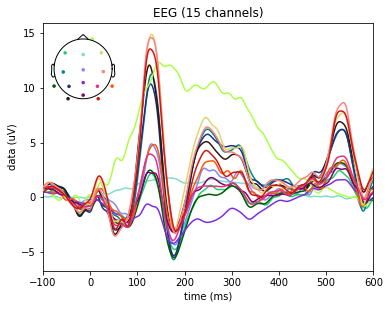

C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [22]:
%matplotlib inline
epochs.average().plot(spatial_colors=True);

## Plot blinks
Average of all blink trials, time-locked to peak of blink.
Blinks defined based on EOG channels (not ICA)

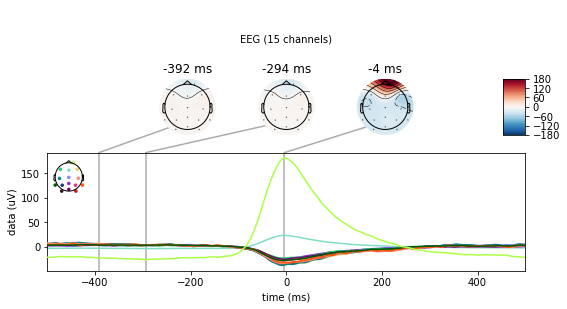

In [23]:
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
reject = dict(eeg=600e-6) # don't fit on crazy environmental artefacts
eog_average = mne.preprocessing.create_eog_epochs(raw, reject=reject, picks=picks_eeg).apply_baseline(baseline).average()
eog_average.plot_joint();

## Run ICA to identify and correct ocular artifacts

In [24]:
n_components = .99

ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(epochs.info, meg=False, 
                       eeg=True, eog=False, stim=False, exclude='bads')

ica.fit(epochs, picks=picks, decim=3, reject=None)

<ICA  |  epochs decomposition, fit (fastica): 91260 samples, 6 components, channels used: "eeg">

### Correlate each ICA component with the EOG channel
Above-threshold correlations will show as red bars

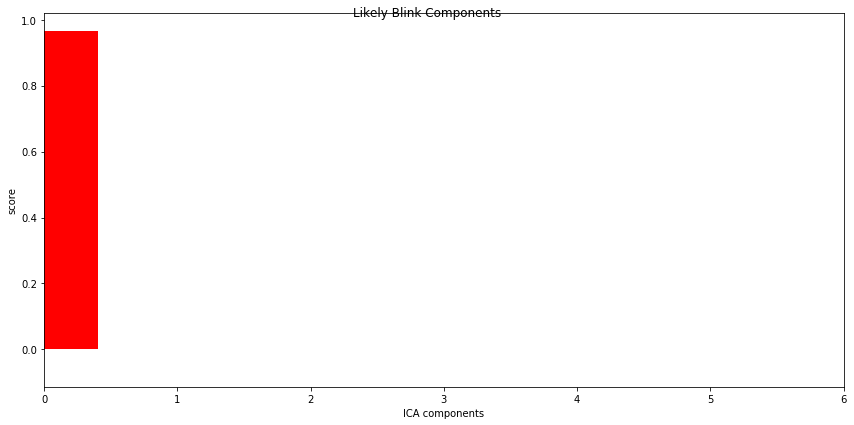

In [25]:
eog_inds_v, scores = ica.find_bads_eog(epochs, threshold=2.0)

ica.plot_scores(scores, exclude=eog_inds_v, title='Likely Blink Components');

### Plot ICA-identified blinks
Red shows with blinks, black shows effect of removing auto-identified blinks

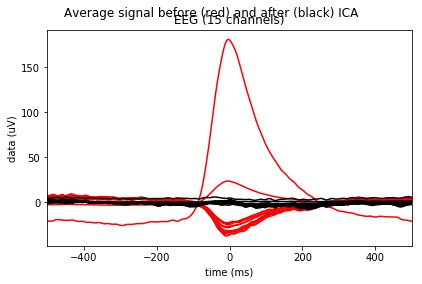

In [26]:
ica.plot_overlay(eog_average, exclude=eog_inds_v, show=False);

### Plot scalp maps of each IC
Ocular artifact components should load heavily over the front of the head and little/not at all elsewhere.

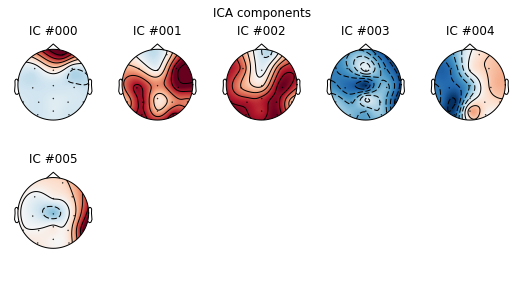

In [27]:
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection

My criteria for rejection are:
1. Obvious ocular artifact (blinks weigh heavily on anterior channels, all same polarity; horizontal movements weight heavily on either side of the eyes, with opposite polarity on each side)
- Raster plots show that component weights heavily on a very low number of trials, and little/not at all on most trials
- "Epochs variance" is high on a low number of trials, and generally low on most trials
- Topo plot shows a very focal effect around a single electrode, with very little/no weighting at most other electrodes (keeping in mind that the topo plots are interpolated so there will be some "smearing" of an effect even at a single electrode) 
- No apparent correlation between average waveform (shown in bottom of raster plot) and an IC with a clear, strong, sensory ERP (i.e., no suggestion of part or all of a P1-N-P2 complex)

Need to manually change the "picks" number for each plot based on visual inspection of the topo plots of the components, above.

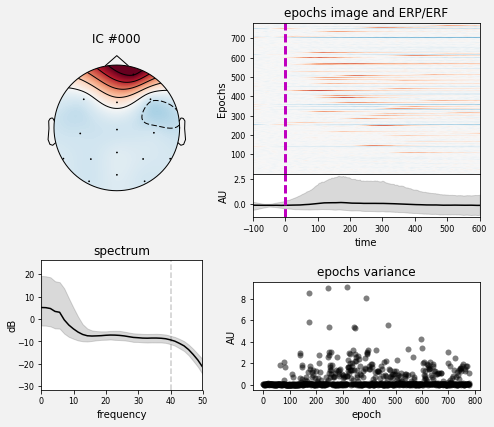

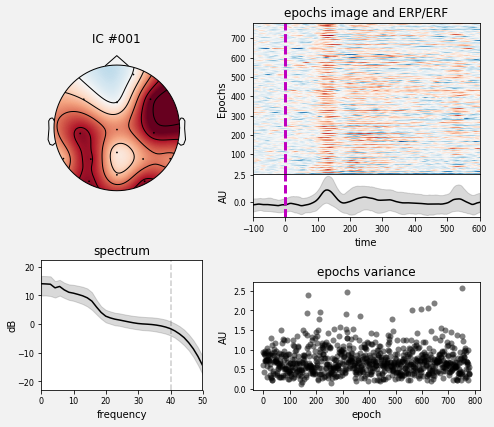

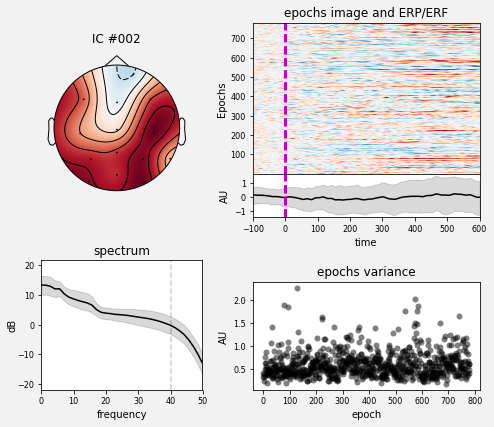

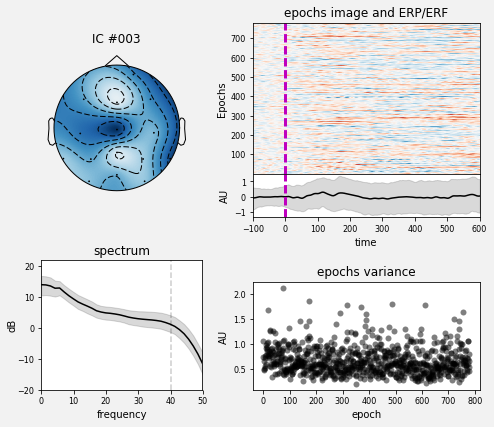

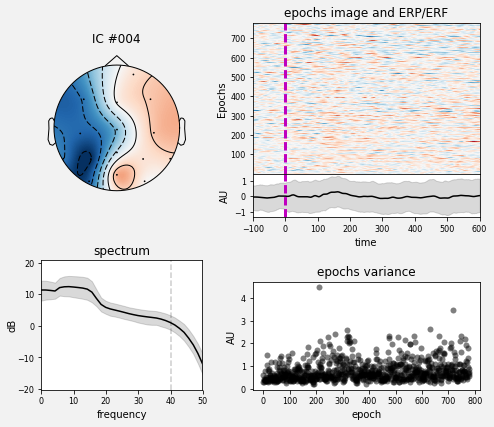

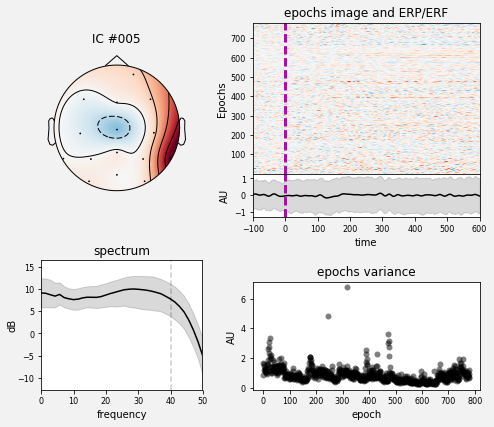

In [28]:
ica.plot_properties(epochs, picks=range(6))

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [29]:
ica.exclude = [0]

## Interpolate electrodes that were manually removed

In [30]:
epochs.interpolate_bads()

<Epochs  |  n_events : 780 (all good), tmin : -0.1 (s), tmax : 0.6 (s), baseline : (None, 0), ~33.5 MB, data loaded,
 'Fix': 389, 'Inverted': 199, 'Upright': 192>

## Apply ICA corrections to data, and re-reference to average mastoids

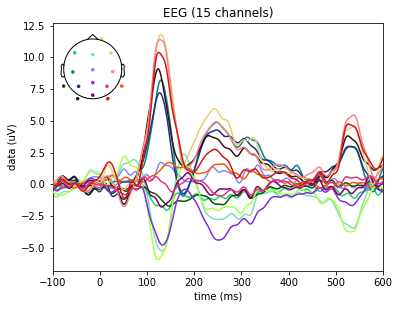

C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [31]:
epochs_postica = ica.apply(epochs.copy()).apply_baseline(baseline)
epochs_postica_mstd = set_eeg_reference(epochs_postica, ref_channels=['TP9','TP10'])[0]

epochs_postica_mstd.average().plot(spatial_colors=True);

In [32]:
epochs_postica_mstd.save(epochs_fname)

## Create Evoked Responses - Averaged epochs for each condition
Use dict comprehension to create a dict with separate entries for each condition. Unhashtag to later load file

In [33]:
evokeds = [epochs_postica_mstd[cond].average() for cond in sorted(cond_of_interest)]

In [34]:
mne.write_evokeds(evoked_fname, evokeds)

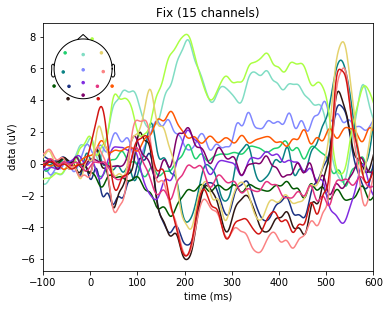

C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


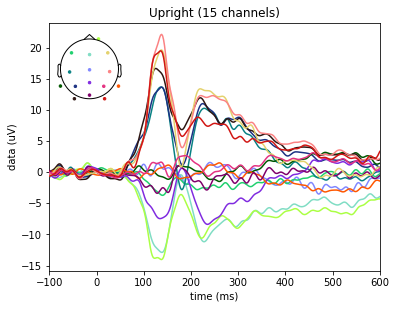

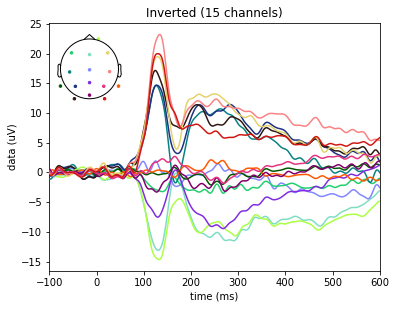

In [35]:
for cond in cond_of_interest:
    evokeds[cond_of_interest.index(cond)].plot(spatial_colors=True, titles=cond);

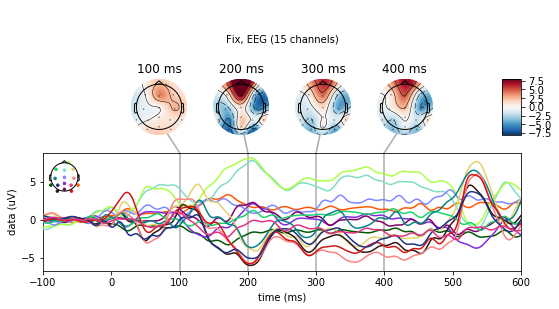

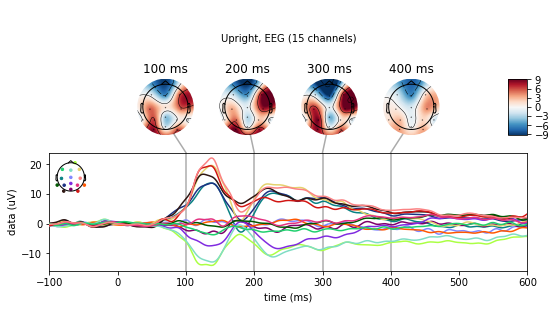

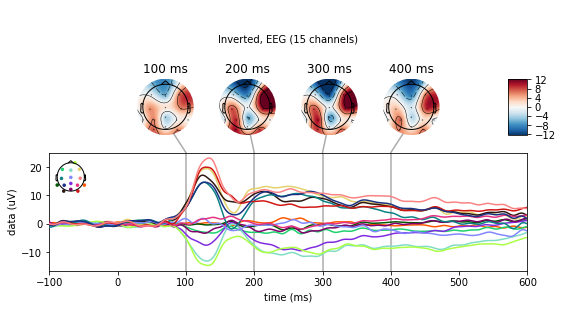

In [36]:
times = np.arange(0.1, 0.5, 0.1)

for cond in cond_of_interest:
    evokeds[cond_of_interest.index(cond)].plot_joint(times=times, title=cond);

### Topoplots per condition

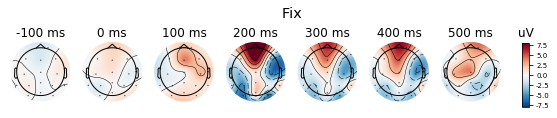

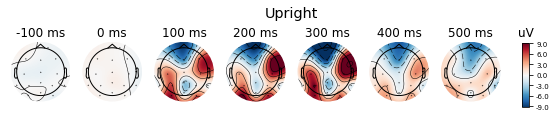

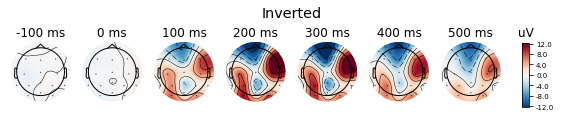

In [37]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(tmin, tmax-.09, 0.1)

for cond in cond_of_interest:
    [evokeds[cond_of_interest.index(cond)].plot_topomap(outlines='skirt', times=times, title=cond)];

## Compute Between-Condition Differences

In [38]:
upavg = epochs["Upright"].average()
invavg  = epochs["Inverted"].average()

inv_up_diff = mne.combine_evoked([invavg, -upavg], weights="equal")

### Plot difference waves

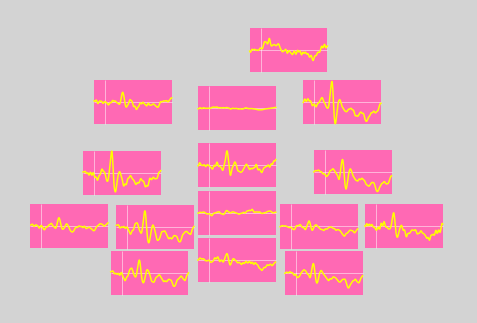

In [49]:
times = np.arange(tmin, tmax-.09, 0.1) 
inv_up_diff.plot_topo(color='yellow', axis_facecolor='hotpink', fig_facecolor = 'lightgrey', font_color='black', vline=[0]);

### Plot topomaps of differences at 100 ms intervals

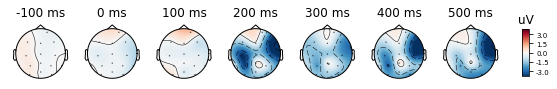

In [40]:
%matplotlib inline
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(tmin, tmax-.09, 0.1)

inv_up_diff.plot_topomap(times=times);

### Plot butterfly plot of differences, with topo maps
Specify times that peak differences are predicted and/or observed. May have to plot, guess peak times, replot, etc. until you get the times just right.

<IPython.core.display.Javascript object>


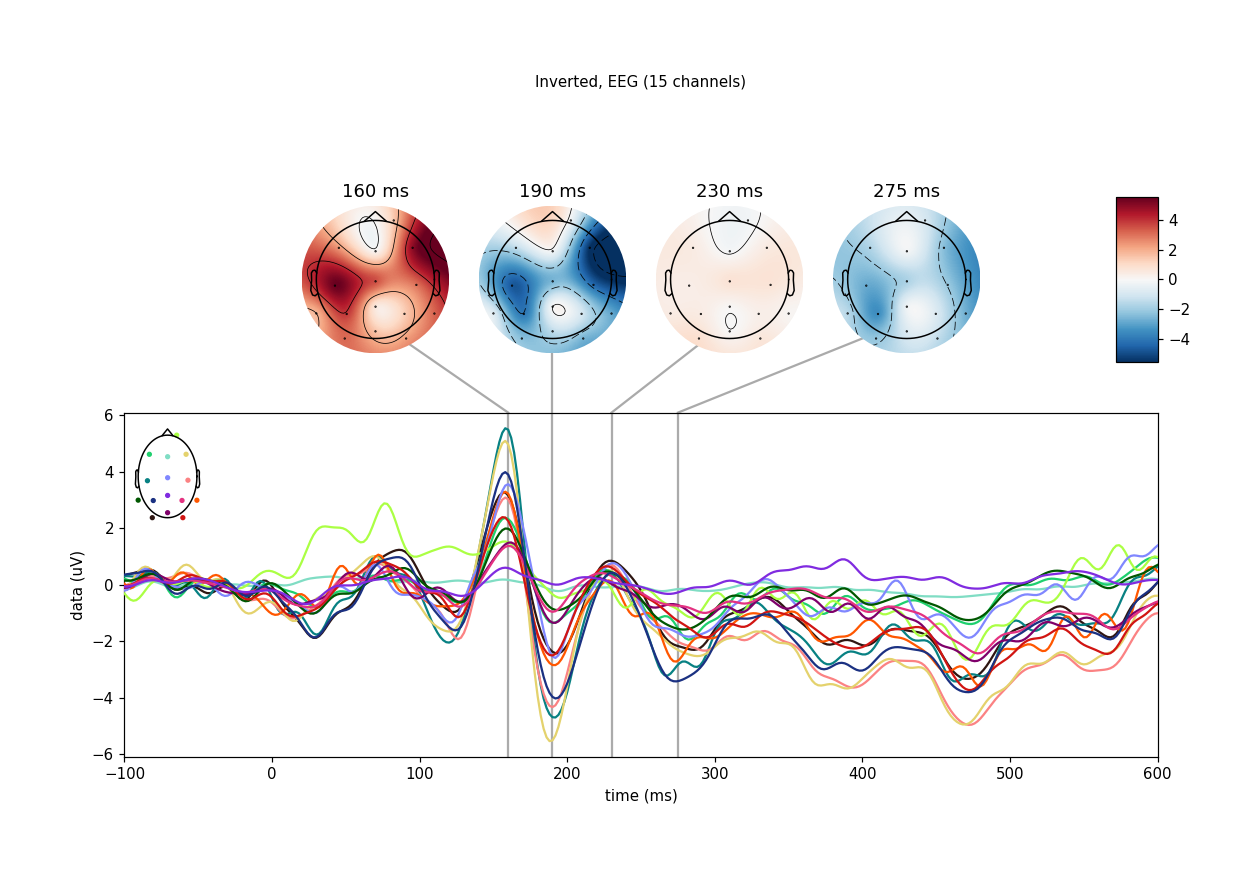

In [54]:
%matplotlib notebook
times = [.16,.190,.23,.275]
inv_up_diff.plot_joint(times=times, title=cond);